In [ ]:
!pip install pydub
# !pip install numpy==1.25.0
!pip install tensorflow==2.13.0 numpy==1.23.5 protobuf==4.25.7 jax==0.4.30 jaxlib==0.4.30
!pip install tensorflow==2.13 tensorflow-datasets librosa soundfile

In [ ]:
import tensorflow_datasets as tfds
import pydub
data_dir = "speech_commands"
dataset, info = tfds.load("speech_commands", with_info=True, as_supervised=True, data_dir=data_dir)

print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling speech_commands/speech_commands/incomplete.W693FT_0.0.3/speech_commands-train.tfrecord*...:   0%|   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling speech_commands/speech_commands/incomplete.W693FT_0.0.3/speech_commands-validation.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling speech_commands/speech_commands/incomplete.W693FT_0.0.3/speech_commands-test.tfrecord*...:   0%|    …

Dataset speech_commands downloaded and prepared to speech_commands/speech_commands/0.0.3. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these backgro

In [ ]:
import numpy as np
import librosa
import tensorflow_datasets as tfds
import tensorflow as tf
import scipy.fftpack
import matplotlib.pyplot as plt
def preprocess_audio_librosa(audio, label):
    # Cast tensor -> numpy
    audio = tf.cast(audio, tf.float32)
    def _librosa_mfcc(y_np):
        import librosa
        import numpy as np
        import scipy.fftpack

        y_np = y_np.numpy().astype(np.float32)  # CẦN DÒNG NÀY
        y_np = y_np / 32768.0  # Chuẩn hóa từ int16 về float32 [-1, 1]

        # cắt còn 1 giây nếu quá dài
        sr = 16000
        y_np = y_np[:sr]

        stft = librosa.stft(y_np, n_fft=256, hop_length=128, win_length=256, window='hann')
        spectrogram = np.abs(stft)**2

        mel_filter = librosa.filters.mel(sr=sr, n_fft=256, n_mels=40, fmin=20, fmax=4000)
        mel_spectrogram = np.dot(mel_filter, spectrogram)
        log_mel_spectrogram = np.log(mel_spectrogram + 1e-6)

        mfcc = scipy.fftpack.dct(log_mel_spectrogram, axis=0, norm='ortho')[0:13]
        mfcc = mfcc.T  # (time, 13)

        if mfcc.shape[0] < 124:
            pad = 124 - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:124, :]

        mfcc = np.expand_dims(mfcc, axis=-1)
        return mfcc.astype(np.float32)

    mfcc = tf.py_function(func=_librosa_mfcc, inp=[audio], Tout=tf.float32)
    mfcc.set_shape((124, 13, 1))
    return mfcc, label


def tf_preprocess(audio, label):
    return preprocess_audio_librosa(audio, label)

train_ds = dataset["train"].map(tf_preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = dataset["validation"].map(tf_preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = dataset["test"].map(tf_preprocess).batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape, padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
num_classes = info.features["label"].num_classes
input_shape = (124, 13, 1)
model = create_model(input_shape, num_classes)
class LearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}: Learning Rate = {lr}")
# Huấn luyện mô hình
history=model.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[LearningRateCallback()])
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/10
2672/2673 [============================>.] - ETA: 0s - loss: 0.7559 - accuracy: 0.7728
Epoch 1: Learning Rate = 0.0010000000474974513
2673/2673 [==============================] - 483s 177ms/step - loss: 0.7559 - accuracy: 0.7728 - val_loss: 0.4846 - val_accuracy: 0.8424
Epoch 2/10
2672/2673 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8827
Epoch 2: Learning Rate = 0.0010000000474974513
2673/2673 [==============================] - 470s 176ms/step - loss: 0.3752 - accuracy: 0.8827 - val_loss: 0.3424 - val_accuracy: 0.8964
Epoch 3/10
2672/2673 [============================>.] - ETA: 0s - loss: 0.2839 - accuracy: 0.9114
Epoch 3: Learning Rate = 0.0010000000474974513
2673/2673 [==============================] - 469s 175ms/step - loss: 0.2839 - accuracy: 0.9114 - val_loss: 0.2641 - val_accuracy: 0.9179
Epoch 4/10
2672/2673 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.9248
Epoch 4: Learning Rate = 0.0010000000474974513
2673/2673

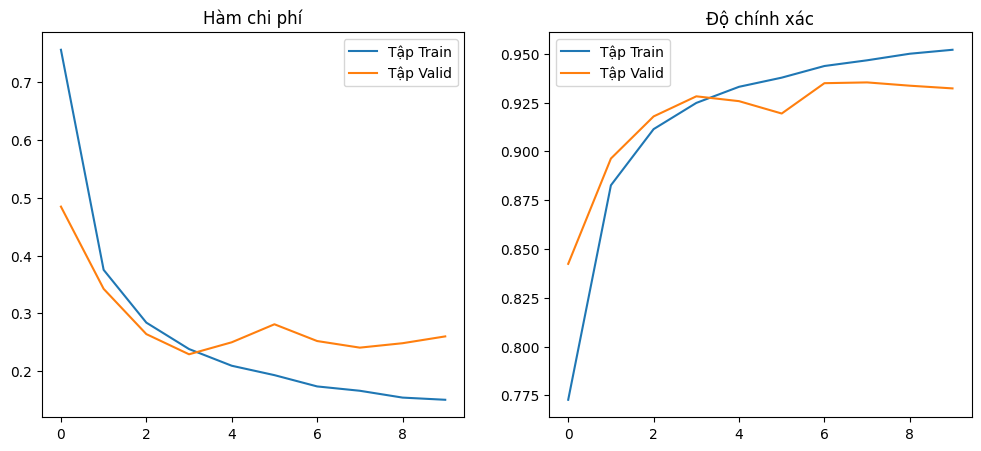

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Tập Train')
plt.plot(history.history['val_loss'], label='Tập Valid')
plt.legend()
plt.title('Hàm chi phí')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Tập Train')
plt.plot(history.history['val_accuracy'], label='Tập Valid')
plt.legend()
plt.title('Độ chính xác')
plt.show()

1/1 [==============================] - 0s 141ms/step
Label thực: stop
Dự đoán: stop


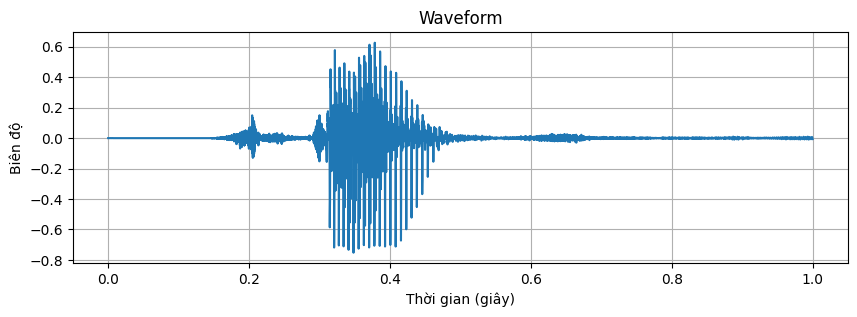

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
label_names = info.features["label"].names

# Lấy 1 mẫu random từ tập test (ví dụ)
test_ds = dataset["test"].take(1)  # lấy 1 mẫu

for audio, label in test_ds:
    audio_np = audio.numpy().astype(np.float32)/32780.0
    def compute_mfcc_from_audio_np(y_np, sr=16000):
        import librosa
        import scipy.fftpack
        y_np = y_np[:sr]  # 1 giây
        stft = librosa.stft(y_np, n_fft=256, hop_length=128, win_length=256, window='hann')
        spectrogram = np.abs(stft)**2
        mel_filter = librosa.filters.mel(sr=sr, n_fft=256, n_mels=40, fmin=20, fmax=4000)
        mel_spectrogram = np.dot(mel_filter, spectrogram)
        log_mel_spectrogram = np.log(mel_spectrogram + 1e-6)
        mfcc = scipy.fftpack.dct(log_mel_spectrogram, axis=0, norm='ortho')[0:13]
        mfcc = mfcc.T
        if mfcc.shape[0] < 124:
            pad = 124 - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:124, :]
        mfcc = np.expand_dims(mfcc, axis=-1).astype(np.float32)
        return mfcc

    mfcc = compute_mfcc_from_audio_np(audio_np)
    input_data = np.expand_dims(mfcc, axis=0)  # batch size 1

    prediction = model.predict(input_data)
    predicted_label_index = np.argmax(prediction[0])
    predicted_label_name = label_names[predicted_label_index]

    print(f"Label thực: {label_names[label.numpy()]}")
    print(f"Dự đoán: {predicted_label_name}")
def plot_waveform(y, sr=16000):
    plt.figure(figsize=(10, 3))
    plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
    plt.title("Waveform")
    plt.xlabel("Thời gian (giây)")
    plt.ylabel("Biên độ")
    plt.grid()
    plt.show()

plot_waveform(audio_np, 16000)

In [ ]:
from pydub import AudioSegment

# Đường dẫn đến file MP3
mp3_file = "/content/stop.mp3"

# Đường dẫn đến file WAV đầu ra
wav_file = "/content/stop.wav"

# Chuyển đổi
sound = AudioSegment.from_mp3(mp3_file)
sound = sound.set_channels(1)  # chuyển stereo sang mono
sound = sound.set_frame_rate(16000)
sound.export(wav_file, format="wav")

<_io.BufferedRandom name='/content/stop.wav'>

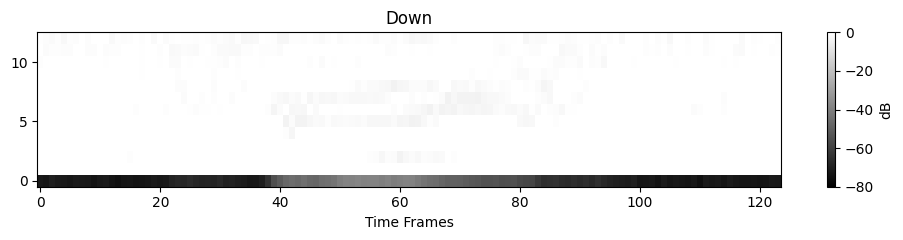

In [ ]:
# @title Default title text
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Đường dẫn file wav muốn test
wav_path = "/content/down_2.wav"
sr = 16000
#wav_path1 = "/content/no.wav"

audio_np, _ = librosa.load(wav_path, sr=sr, mono=True)
#audio_np1,_ = librosa.load(wav_path1, sr=sr, mono=True)

def compute_mfcc_from_audio_np(y_np, sr=16000):
    import scipy.fftpack
    #y_np = y_np[8000:24000]  # 1 giây
    stft = librosa.stft(y_np, n_fft=256, hop_length=128, win_length=256, window='hann')
    spectrogram = np.abs(stft)**2
    mel_filter = librosa.filters.mel(sr=sr, n_fft=256, n_mels=40, fmin=20, fmax=4000)
    mel_spectrogram = np.dot(mel_filter, spectrogram)
    log_mel_spectrogram = np.log(mel_spectrogram + 1e-6)
    mfcc = scipy.fftpack.dct(log_mel_spectrogram, axis=0, norm='ortho')[0:13]
    mfcc = mfcc.T
    if mfcc.shape[0] < 124:
        pad = 124 - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:124, :]
    mfcc = np.expand_dims(mfcc, axis=-1).astype(np.float32)
    return mfcc


mfcc = compute_mfcc_from_audio_np(audio_np)

# input_data = np.expand_dims(mfcc, axis=0)  # batch size 1
# prediction = model.predict(input_data)
# predicted_label_index = np.argmax(prediction[0])
# predicted_label_name = label_names[predicted_label_index]

# print(f"Dự đoán từ khóa: {predicted_label_name}")

# 5. Vẽ waveform
# def plot_waveform(y, sr=16000):
#     plt.figure(figsize=(10, 3))
#     plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
#     plt.title("Waveform")
#     plt.xlabel("Thời gian (giây)")
#     plt.ylabel("Biên độ")
#     plt.grid()
#     plt.show()
# plot_waveform(audio_np, sr)
# def plot_mel_spectrogram(y_np, sr=16000):
#     S = librosa.feature.melspectrogram(
#         y=y_np, sr=sr, n_fft=256, hop_length=128,
#         win_length=256, n_mels=40, fmin=20, fmax=4000,
#         power=2.0
#     )
#     log_S = np.log(S + 1e-6)

#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(log_S, sr=sr, hop_length=128,
#                              x_axis='time', y_axis='mel', fmax=4000)
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Log-Mel Spectrogram')
#     plt.tight_layout()
#     plt.show()
# plot_mel_spectrogram(audio_np, sr)
def plot_mfcc(mfcc):
    mfcc_display = np.squeeze(mfcc, axis=-1).T  # shape: (13, time)
    plt.figure(figsize=(10, 2.5))
    plt.imshow(mfcc_display, aspect='auto', origin='lower',
               interpolation='nearest', cmap='gray', vmin=-80, vmax=0)
    plt.title('Down')
    plt.xlabel('Time Frames')
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()
plot_mfcc(mfcc)




# for i, prob in enumerate(prediction[0]):
#     print(f"{label_names[i]}: {prob * 100:.2f}%")


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
from scipy.io import wavfile
def compute_mfcc(y, sr=16000):
    y = y[:sr]  # cắt 1 giây đầu

    stft = librosa.stft(y, n_fft=256, hop_length=128, win_length=256, window='hann')
    spectrogram = np.abs(stft)**2
    mel_filter = librosa.filters.mel(sr=sr, n_fft=256, n_mels=40, fmin=20, fmax=4000)
    mel_spectrogram = np.dot(mel_filter, spectrogram)
    log_mel_spectrogram = np.log(mel_spectrogram + 1e-6)
    mfcc = scipy.fftpack.dct(log_mel_spectrogram, axis=0, norm='ortho')[0:13]
    mfcc = mfcc.T  # (time, 13)
    if mfcc.shape[0] < 124:
        pad = 124 - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:124, :]
    return mfcc

# Đường dẫn file wav
filepath = "/content/sample_from_dataset.wav"
# Load audio
y, sr = librosa.load(filepath, sr=16000)

# Tính MFCC
mfcc = compute_mfcc(y, sr)

#Vẽ waveform
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Vẽ MFCC
plt.subplot(2, 1, 2)
# MFCC có shape (124, 13)
# Vẽ như hình ảnh (time vs coef)
plt.imshow(mfcc.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("MFCC")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import os # Import module os

model.export("my_speech_model")
converter = tf.lite.TFLiteConverter.from_saved_model("my_speech_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

tflite_filename = "model.tflite"

with open(tflite_filename, "wb") as f:
    f.write(tflite_model)

print("Đã lưu model.tflite")

file_size_bytes = os.path.getsize(tflite_filename)
file_size_kb = file_size_bytes / 1024
file_size_mb = file_size_kb / 1024

print(f"Kích thước file {tflite_filename}: {file_size_bytes} bytes ({file_size_kb:.2f} KB, {file_size_mb:.2f} MB)")

Saved artifact at 'my_speech_model'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 124, 13, 1)
  Returns:
    float32 Tensor, shape=(None, 12)
✅ Đã lưu model.tflite
Kích thước file model.tflite: 348608 bytes (340.44 KB, 0.33 MB)


In [ ]:
from pydub import AudioSegment

# Đường dẫn đến file MP3
mp3_file = "/content/go.mp3"

# Đường dẫn đến file WAV đầu ra
wav_file = "/content/go.wav"

# Chuyển đổi
sound = AudioSegment.from_mp3(mp3_file)
sound = sound.set_channels(1)  # chuyển stereo sang mono
sound = sound.set_frame_rate(16000)
sound.export(wav_file, format="wav")


In [ ]:

.import tensorflow as tf
print("TensorFlow version:", tf.__version__)


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack


def compute_mfcc_from_audio_np(y_np, sr=16000):
    import scipy.fftpack
    #y_np = y_np[8000:24000]  # 1 giây
    stft = librosa.stft(y_np, n_fft=256, hop_length=128, win_length=256, window='hann')
    spectrogram = np.abs(stft)**2
    mel_filter = librosa.filters.mel(sr=sr, n_fft=256, n_mels=40, fmin=20, fmax=4000)
    mel_spectrogram = np.dot(mel_filter, spectrogram)
    log_mel_spectrogram = np.log(mel_spectrogram + 1e-6)
    mfcc = scipy.fftpack.dct(log_mel_spectrogram, axis=0, norm='ortho')[0:13]
    mfcc = mfcc.T
    if mfcc.shape[0] < 124:
        pad = 124 - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:124, :]
    mfcc = np.expand_dims(mfcc, axis=-1).astype(np.float32)
    return mfcc